<a href="https://colab.research.google.com/github/habakan/cs231n_handson/blob/main/notebook/2_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## preparation of dataset

In [1]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2022-11-09 14:27:24--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.1’

cifar-10-python.tar 100%[===================>] 162.60M  94.7MB/s    in 1.7s    

2022-11-09 14:27:26 (94.7 MB/s) - ‘cifar-10-python.tar.gz.1’ saved [170498071/170498071]



In [2]:
!tar -zxvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [3]:
!cat cifar-10-batches-py/readme.html

<meta HTTP-EQUIV="REFRESH" content="0; url=http://www.cs.toronto.edu/~kriz/cifar.html">


In [4]:
import os
import pickle
import numpy as np

def unpickle(file_path):
  with open(file_path, 'rb') as fo:
    data_dict = pickle.load(fo, encoding='bytes')
  return data_dict

def load_CIFAR10(data_dir):
  X_train_list = []
  y_train_list = []

  for train_idx in [1, 2, 3, 4, 5]:
    data_dict = unpickle(os.path.join(data_dir, 'data_batch_'+str(train_idx)))
    X_train_list.append(data_dict[b'data'])
    y_train_list.append(data_dict[b'labels'])

  data_dict = unpickle(os.path.join(data_dir, 'test_batch'))
  X_test = data_dict[b'data']
  y_test = data_dict[b'labels']
  return np.vstack(X_train_list), np.array(y_train_list).reshape(-1), X_test, y_test

In [5]:
Xtr, Ytr, Xte, Yte = load_CIFAR10('./cifar-10-batches-py')

In [6]:
Xtr_rows = Xtr.reshape(Xtr.shape[0], 32 * 32 * 3) # Xtr_rows becomes 50000 x 3072
Xte_rows = Xte.reshape(Xte.shape[0], 32 * 32 * 3) # Xte_rows becomes 10000 x 3072

In [7]:
class NearestNeighbor(object):
  def __init__(self):
    pass

  def train(self, X, y):
    """ X is N x D where each row is an example. Y is 1-dimension of size N """
    # the nearest neighbor classifier simply remembers all the training data
    self.Xtr = X
    self.ytr = y

  def predict(self, X, k=1):
    """ X is N x D where each row is an example we wish to predict label for """
    num_test = X.shape[0]
    # lets make sure that the output type matches the input type
    Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

    # loop over all test rows
    for i in range(num_test):
      # find the nearest training image to the i'th test image
      # using the L1 distance (sum of absolute value differences)
      distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
      '''
      min_index = np.argmin(distances) # get the index with smallest distance
      Ypred[i] = self.ytr[min_index] # predict the label of the nearest example
      '''
      sort_index = np.argsort(distances)
      y_pred_candidates = self.ytr[sort_index[:k]]
      if len(y_pred_candidates) > 1:
        uniqs, counts = np.unique(y_pred_candidates, return_counts=True)
        Ypred[i] = uniqs[counts == np.amax(counts)].max()
      else:
        Ypred[i] = y_pred_candidates[0]

    return Ypred

In [8]:
# assume we have Xtr_rows, Ytr, Xte_rows, Yte as before
# recall Xtr_rows is 50,000 x 3072 matrix
Xval_rows = Xtr_rows[:1000, :] # take first 1000 for validation
Yval = Ytr[:1000]
Xtr_rows = Xtr_rows[1000:, :] # keep last 49,000 for train
Ytr = Ytr[1000:]

# find hyperparameters that work best on the validation set
validation_accuracies = []
for k in [1, 3, 5, 10, 20, 50, 100]:

  # use a particular value of k and evaluation on validation data
  nn = NearestNeighbor()
  nn.train(Xtr_rows, Ytr)
  # here we assume a modified NearestNeighbor class that can take a k as input
  Yval_predict = nn.predict(Xval_rows, k = k)
  acc = np.mean(Yval_predict == Yval)
  print('accuracy: %f' % (acc,))

  # keep track of what works on the validation set
  validation_accuracies.append((k, acc))

accuracy: 0.223000
accuracy: 0.230000
accuracy: 0.257000
accuracy: 0.252000
accuracy: 0.241000
accuracy: 0.219000
accuracy: 0.203000


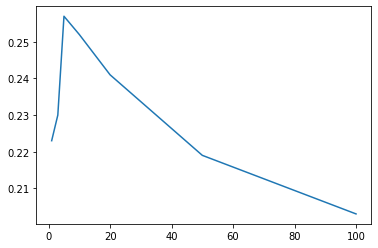

In [9]:
import matplotlib.pyplot as plt

k_list = [validation[0] for validation in validation_accuracies]
acc_list = [validation[1] for validation in validation_accuracies]

plt.plot(k_list, acc_list)
plt.show()